# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay,f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [142]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [143]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

**Validation Set**

Use this set to evaluate your model

In [144]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [145]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [146]:
# put your answer here
df_train.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [147]:
df_train.info()# put your answer here

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [148]:
# put your answer here
print("Missing data in each column (train dataset):\n" + str(df_train.isnull().sum()))


Missing data in each column (train dataset):
text     0
label    0
dtype: int64


4. Check for duplicate rows

In [149]:
# put your answer here
df_train.duplicated().sum()


0

5. Check how many rows belong to each class

In [150]:
# put your answer here
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [151]:
# put your answer here

7. Remove rows with NaN values

In [152]:
# put your answer here

8. Convert all text to lowercase

In [153]:
# put your answer here
df_train['text'] = df_train['text'].str.lower()
df_validation['text'] = df_validation['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

In [154]:
df_train.head(20)

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali na sumunod ang patalastas ng n...,1
2,bet ko. pula ang kulay ng posas,1
3,[username] kakampink,0
4,bakit parang tahimik ang mga pink about doc wi...,1
5,"""ang sinungaling sa umpisa ay sinungaling hang...",1
6,leni kiko,0
7,nahiya si binay sa makati kaya dito na lang sa...,1
8,another reminderhalalan,0
9,[username] maybe because vp leni sen kiko and ...,0


9. Remove digits, URLS and special characters

In [155]:
# put your answer here
#remove digits
df_train['text'] = (df_train['text']
                    .str.replace("\d+", "", regex=True)
                    .str.replace("\n","", regex=True)
                    .str.replace('https?:\/\/.*[\r\n]*', '', regex=True)
                    .str.replace('[^\x00-\x7f]',' ', regex=True)
                    .str.replace('[^\w\s]','', regex=True))

df_validation['text'] = (df_validation['text']
                    .str.replace("\d+", "", regex=True)
                    .str.replace("\n","", regex=True)
                    .str.replace('https?:\/\/.*[\r\n]*', '', regex=True)
                    .str.replace('[^\x00-\x7f]',' ', regex=True)
                    .str.replace('[^\w\s]','', regex=True))

df_test['text'] = (df_test['text']
                    .str.replace("\d+", "", regex=True)
                    .str.replace("\n","", regex=True)
                    .str.replace('https?:\/\/.*[\r\n]*', '', regex=True)
                    .str.replace('[^\x00-\x7f]',' ', regex=True)
                    .str.replace('[^\w\s]','', regex=True))


In [156]:
df_train.head(20)

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali na sumunod ang patalastas ng n...,1
2,bet ko pula ang kulay ng posas,1
3,username kakampink,0
4,bakit parang tahimik ang mga pink about doc wi...,1
5,ang sinungaling sa umpisa ay sinungaling hangg...,1
6,leni kiko,0
7,nahiya si binay sa makati kaya dito na lang sa...,1
8,another reminderhalalan,0
9,username maybe because vp leni sen kiko and th...,0


10. Remove stop words

In [157]:
# put your answer here
stop_words = stopwords.words('english')
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_validation['text'] = df_validation['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_test['text'] = df_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [158]:
tagalog = set(
    """akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

In [159]:
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (tagalog)]))

In [160]:
df_train.head(5)

,text,label
0,presidential candidate mar roxas implies govt ...,1
1,parang mali sumunod patalastas nescaf coffee b...,1
2,bet pula kulay posas,1
3,username kakampink,0
4,parang tahimik pink doc willie ong reaction paper,1


11. Use Stemming or Lemmatization

In [161]:
# put your answer here
def lemmatize_text(text):
    lemmer = WordNetLemmatizer()
    # Tokenize the text and lemmatize each word
    lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
    return " ".join(lemm_tokens)



df_train['text'] =  df_train['text'].apply(lemmatize_text)
df_test['text'] =  df_test['text'].apply(lemmatize_text)
df_validation['text'] =  df_validation['text'].apply(lemmatize_text)

## C. Training your model

12. Put all text training data in variable **X_train**

In [162]:
# put your answer here
X_train = df_train["text"].values

13. Put all training data labels in variable **y_train**

In [163]:
# put your answer here
y_train = df_train["label"].values

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [164]:
# put your answer here
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train_transformed = vectorizer.transform(X_train)

15. Create an instance of `MultinomalNB()`

In [165]:
# put your answer here
model = MultinomialNB(alpha=0.1)

16. Train the model using `.fit()`

In [166]:
# put your answer here
model.fit(X_train_transformed, y_train)

MultinomialNB(alpha=0.1)

## D. Evaluate your model

In [167]:
X_validation = df_validation['text'].values
y_validation_pred = df_validation['label'].values

In [168]:
X_validation_transformed = vectorizer.transform(X_validation)

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [169]:
# put your answer here
predictions = model.predict(X_validation_transformed)

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [170]:
# put your answer here
accuracy = accuracy_score(y_validation_pred, predictions)
precision = precision_score(y_validation_pred, predictions)
recall = recall_score(y_validation_pred, predictions)
balanced_accuracy = balanced_accuracy_score(y_validation_pred, predictions)

print("Accuracy:",round(100*accuracy,2),'%')
print("Precision:", round(100*precision,2),'%')
print("Recall:", round(100*recall,2),'%')
print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')



Accuracy: 82.54 %
Precision: 81.41 %
Recall: 84.81 %
Balanced accuracy: 82.51 %


19. Create a confusion matrix using the **validation dataset**

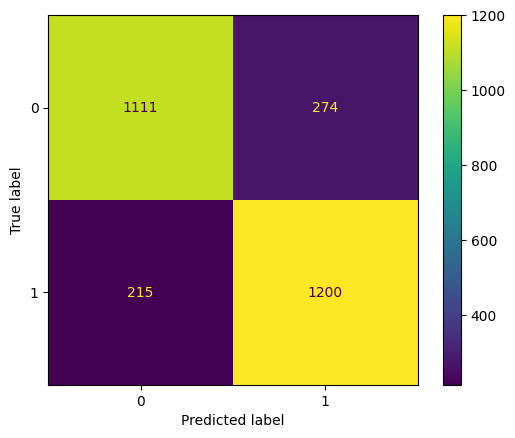

In [171]:
# put your answer here
cm = confusion_matrix(y_validation_pred, predictions)

 #Plot the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [172]:
# put your answer here
X_test = df_test['text'].values
X_test_transformed = vectorizer.transform(X_test)

y_test = df_test['label'].values

In [173]:
y_test_pred = model.predict(X_test_transformed)

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [174]:
# put your answer here
accuracy = accuracy_score(y_test_pred, y_test)
precision = precision_score(y_test_pred, y_test)
recall = recall_score(y_test_pred, y_test)
f1_accuracy = f1_score(y_test_pred, y_test)

print("Accuracy:",round(100*accuracy,2),'%')
print("Precision:", round(100*precision,2),'%')
print("Recall:", round(100*recall,2),'%')
print("Balanced accuracy:",round(100*f1_accuracy,2),'%')

Accuracy: 81.78 %
Precision: 84.19 %
Recall: 80.18 %
Balanced accuracy: 82.14 %


22. Create a confusion matrix using the **test dataset**

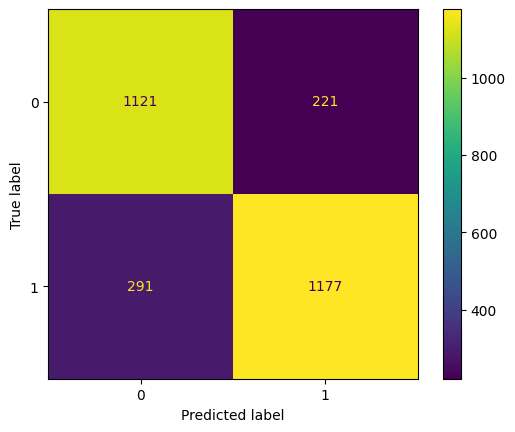

In [175]:
# put your answer here
cm = confusion_matrix(y_test_pred, y_test)

 #Plot the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [176]:
text = "dahil sa exercise na to naging masaya ako"
text_transformed = vectorizer.transform([text])
prediction = model.predict(text_transformed)
prediction

array([0])

24. Test the model by providing a hate speech input. The model should predict it as 1

In [178]:
# put your answer here
text = "ang init ng ulo ko ang gulo gulo ng paligid ang sarap talaga sumigaw ng putangina"
#text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (tagalog)]))
#text = (text
 #                   .replace("\d+", "", regex=True)
#                    .replace("\n","", regex=True)
 #                   .replace('https?:\/\/.*[\r\n]*', '', regex=True)
 ###                   .replace('[^\x00-\x7f]',' ', regex=True)
  #                  .replace('[^\w\s]','', regex=True))

text_transformed = vectorizer.transform([text])
prediction = model.predict(text_transformed)
prediction

array([1])